# Germany correlated sampling 

Objective: make a plot of the analysis for Germany, where sampling is based on correlating structure after Nguyen et al. (2020) instead of random sampling.

In [1]:
from pathlib import Path
import geopandas as gpd
import pandas as pd
import os
import matplotlib.pyplot as plt
import pygeos as pyg
import sys
import json
from shapely import wkt
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba_array
from matplotlib.lines import Line2D
from tqdm.notebook import tqdm

sys.path.append("../scripts")
sys.path.append("..")
from utils import *
from Europe_utils import *
from visualisations_new import aggregate_results_step1, aggregate_results_step2, percolation_summary, main


In [2]:
config = load_config(file = 'config_eventbased_2.json')
config

{'comment': 'This json file contains the paths to the directories where the in- and output files are located',
 'paths': {'data': WindowsPath('D:/Python/europe_flood_road_disruption/data'),
  'output_data': WindowsPath('D:/Python/europe_flood_road_disruption/data/output'),
  'output_images': WindowsPath('D:/Python/europe_flood_road_disruption/visualisations'),
  'NUTS_shapes': WindowsPath('D:/Europe_trade_disruptions/NUTS-2_shapes/NUTS_2016'),
  'graphs_folder': WindowsPath('D:/Europe_percolation/frederiques_networks'),
  'preproc_output': WindowsPath('D:/Europe_percolation/event_sampling_vs2/preproc_output'),
  'main_output': WindowsPath('D:/Europe_percolation/event_sampling_vs2/main_output')}}

In [3]:
#Add all years to a seperate df
folder = config['paths']['main_output'] / 'germany' / 'finished'
folder.exists()

if 'df' in locals(): del df

for year_csv in tqdm(folder.iterdir()):
    year = year_csv.stem
    if not year_csv.exists():
        raise Exception('File {} does not exist'.format(year_csv))
        
    new_row = pd.read_csv(year_csv,sep=';',index_col=0)
    new_row.index = [int(year)]
    if not 'df' in locals():
        df = new_row
    else:
        df = df.append(new_row)
        
df.sort_index(inplace=True)

df

0it [00:00, ?it/s]

,year,disrupted,avg extra time,no detour
4,4,0.000000,0.000000,0.000000
5,5,35.277383,0.142233,10.384068
12,12,8.819346,0.025458,0.000000
18,18,0.284495,0.000120,0.000000
20,20,5.120910,0.002973,0.000000
...,...,...,...,...
9945,9945,0.000000,0.000000,0.000000
9958,9958,31.294452,0.086652,0.000000
9974,9974,2.987198,0.001380,0.000000
9975,9975,50.071124,0.151076,0.000000


### Need to get some information from scheduled jsons, namely the basin aoi and the inundated AoIs

In [4]:
df[['nr_basinfloods_100','nr_basinfloods_50','nr_microfloods_100','nr_microfloods_50']] = None
df

folder = config['paths']['main_output'] / 'germany' / 'scheduled'
folder.exists()

#year_json = folder / 'year_2.json'
#year_json.exists()

for year_json in tqdm(folder.iterdir()):
    with open(year_json) as j:
        s = json.load(j)
        key = list(s['data'].keys())[0]
        #basin_floods = s['data'][year]['microfloods']

        df.at[int(key),'nr_basinfloods_100'] = len([basin_flood for basin_flood in s['data'][key]['microfloods'] if basin_flood['return_period'] > 100])
        df.at[int(key),'nr_basinfloods_50'] = len([basin_flood for basin_flood in s['data'][key]['microfloods'] if basin_flood['return_period'] > 50])

        aoi100 = [basin_flood['cell_aois'] for basin_flood in s['data'][key]['microfloods'] if basin_flood['return_period'] > 100]
        df.at[int(key),'nr_microfloods_100'] = len(list(set([j for i in aoi100 for j in i])))

        aoi50 = [basin_flood['cell_aois'] for basin_flood in s['data'][key]['microfloods'] if basin_flood['return_period'] > 50]
        df.at[int(key),'nr_microfloods_50'] = len(list(set([j for i in aoi50 for j in i])))
        
df

0it [00:00, ?it/s]

,year,disrupted,avg extra time,no detour,nr_basinfloods_100,nr_basinfloods_50,nr_microfloods_100,nr_microfloods_50
4,4.0,0.000000,0.000000,0.000000,0,1,0,4
5,5.0,35.277383,0.142233,10.384068,36,45,1373,1886
12,12.0,8.819346,0.025458,0.000000,1,3,0,18
18,18.0,0.284495,0.000120,0.000000,1,8,2,450
20,20.0,5.120910,0.002973,0.000000,0,10,0,220
...,...,...,...,...,...,...,...,...
9950,NaN,NaN,NaN,NaN,0,1,0,12
9952,NaN,NaN,NaN,NaN,0,4,0,71
9983,NaN,NaN,NaN,NaN,0,1,0,6
9992,NaN,NaN,NaN,NaN,0,1,0,20


### Prepare plots
Plot 1: timeline with amount of AoI hit per year.

Plot 2ABC: scatter plot (x: AoI combinations, y: disrupted,| avg extra time, no detour)

todo: corrigeren voor punten/AoI? niet in Duitsland?

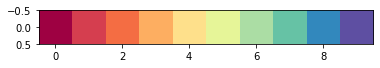

In [5]:
import matplotlib as mpl
#colorscheme
colors = ['#9e0142','#d53e4f','#f46d43','#fdae61','#fee08b','#e6f598','#abdda4','#66c2a5','#3288bd','#5e4fa2']
roads_cc = colors[0:5][::-1] #We iterate over the roads in reversed order
roads_lw_cc = [1,0.7,0.5,.3,.3][::-1] #linewidth cycler
nuts_fill = '#abdda4'
nuts_border = '#66c2a5'

length_cols = ['Total_Edge_Length', 'Len_Motorway', 'Len_Trunk', 'Len_Primary', 'Len_Secondary', 'Len_Tertiary']

road_types = ['motorway','trunk','primary','secondary','tertiary']

plt.imshow(to_rgba_array(colors).reshape(1,len(colors),4))
plt.show()


font = {'family' : 'arial'}
mpl.rc('font', **font)  # pass in the font dict as kwargs
grey = '#444444'
mpl.rcParams.update({'text.color' : grey,
                     'axes.labelcolor' : grey,
                     'axes.titlecolor' : grey,
                     'axes.edgecolor' : grey,
                     'xtick.color': grey, #This is the color of the categories on y- and x-axis
                     'ytick.color': grey                    })

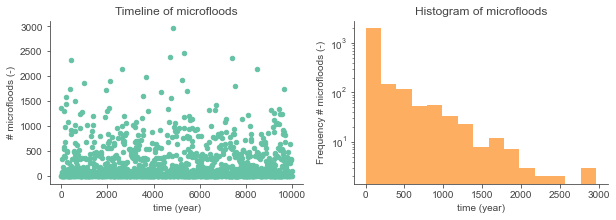

In [6]:
fig,axes = plt.subplots(1,2,figsize=(10,3))

df.plot(x='year',y='nr_microfloods_100',kind='scatter',ax=axes[0],color=colors[7])
df.plot(x='year',y='nr_microfloods_100',kind='hist',ax=axes[1],color=colors[3],bins=15,legend=None)
axes[1].set_yscale('log')

axes[0].set_title('Timeline of microfloods')
axes[0].set_ylabel('# microfloods (-)')
axes[0].set_xlabel('time (year)')

axes[1].set_title('Histogram of microfloods')
axes[1].set_ylabel('Frequency # microfloods (-)')
axes[1].set_xlabel('time (year)')

for ax in axes:
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

In [7]:
dest_dir = Path('Germany-sampling')
this_version = 'v2'
name = 'flood_frequency'
#fig.savefig(dest_dir / (this_version + '_' + name + '.png'),dpi=300,bbox_inches='tight')
#fig.savefig(dest_dir / (this_version + '_' + name + '.pdf'),bbox_inches='tight')

### Shading

create summary statistics for the sampling as well to plot bandwidth

In [8]:
df.head(n=8)

,year,disrupted,avg extra time,no detour,nr_basinfloods_100,nr_basinfloods_50,nr_microfloods_100,nr_microfloods_50
4,4.0,0.000000,0.000000,0.000000,0,1,0,4
5,5.0,35.277383,0.142233,10.384068,36,45,1373,1886
12,12.0,8.819346,0.025458,0.000000,1,3,0,18
18,18.0,0.284495,0.000120,0.000000,1,8,2,450
20,20.0,5.120910,0.002973,0.000000,0,10,0,220
28,28.0,0.000000,0.000000,0.000000,3,4,39,51
30,30.0,25.889047,0.061379,0.000000,5,13,61,265
35,35.0,34.850640,0.082849,0.000000,10,20,97,196


In [9]:
column = 'nr_microfloods_100'
dfs = df.sort_values(by=column)
dfs
groups = df.groupby(by=column)

In [10]:
groups.describe()

year                                                     \
                    count         mean          std     min      25%     50%   
nr_microfloods_100                                                             
0                   294.0  5042.088435  2935.448490     4.0  2618.25  5261.0   
1                     2.0  3541.500000  2061.216267  2084.0  2812.75  3541.5   
2                     2.0  3580.000000  5037.428709    18.0  1799.00  3580.0   
4                    21.0  5647.666667  2967.239767   874.0  3789.00  5651.0   
5                    18.0  4690.000000  2814.248724   536.0  2083.75  4855.0   
...                   ...          ...          ...     ...      ...     ...   
2388                  1.0  4732.000000          NaN  4732.0  4732.00  4732.0   
2473                  1.0  5338.000000          NaN  5338.0  5338.00  5338.0   
2912                  0.0          NaN          NaN     NaN      NaN     NaN   
2967                  1.0  4862.000000          NaN  4862.0  4862.00  4862.0   
2970                  0.0          NaN          NaN     NaN      NaN     NaN   

                                    disrupted             ... avg extra time  \
                        75%     max     count       mean  ...            75%   
nr_microfloods_100                                        ...                  
0                   7458.00  9974.0     294.0   4.262587  ...       0.013101   
1                   4270.25  4999.0       2.0   0.711238  ...       0.001727   
2                   5361.00  7142.0       2.0  23.328592  ...       0.110783   
4                   8256.00  9786.0      21.0   3.075256  ...       0.001380   
5                   7336.25  8312.0      18.0   0.616406  ...       0.000000   
...                     ...     ...       ...        ...  ...            ...   
2388                4732.00  4732.0       1.0  82.076814  ...       1.952932   
2473                5338.00  5338.0       1.0  96.159317  ...       2.106820   
2912                    NaN     NaN       0.0        NaN  ...            NaN   
2967                4862.00  4862.0       1.0  91.607397  ...       1.910369   
2970                    NaN     NaN       0.0        NaN  ...            NaN   

                             no detour                                        \
                         max     count       mean  std        min        25%   
nr_microfloods_100                                                             
0                   0.074832     294.0   0.000000  0.0   0.000000   0.000000   
1                   0.002303       2.0   0.000000  0.0   0.000000   0.000000   
2                   0.147670       2.0   0.000000  0.0   0.000000   0.000000   
4                   0.041991      21.0   0.000000  0.0   0.000000   0.000000   
5                   0.044948      18.0   0.000000  0.0   0.000000   0.000000   
...                      ...       ...        ...  ...        ...        ...   
2388                1.952932       1.0   0.000000  NaN   0.000000   0.000000   
2473                2.106820       1.0  20.199147  NaN  20.199147  20.199147   
2912                     NaN       0.0        NaN  NaN        NaN        NaN   
2967                1.910369       1.0  15.362731  NaN  15.362731  15.362731   
2970                     NaN       0.0        NaN  NaN        NaN        NaN   

                                                     
                          50%        75%        max  
nr_microfloods_100                                   
0                    0.000000   0.000000   0.000000  
1                    0.000000   0.000000   0.000000  
2                    0.000000   0.000000   0.000000  
4                    0.000000   0.000000   0.000000  
5                    0.000000   0.000000   0.000000  
...                       ...        ...        ...  
2388                 0.000000   0.000000   0.000000  
2473                20.199147  20.199147  20.199147  
2912                      NaN        NaN        NaN  
2967      

Conclusion: it is not possible to make uniform statistics of these, because the groups are very different in size...

### Disrupted routes plot

In [11]:
### Load data of regular analysis
config_reg = load_config(file='config-KeesWork.json')
df_ref,df_abs,df_rel = main(config_reg)

 -------- main() starting --------
Succesfully loaded source file as dataframe, with columns:
Index(['AoI combinations', 'disrupted', 'avg extra time', 'AoI removed',
       'no detour', 'country'],
      dtype='object')
Available for 30 countries
Grouping per AoI-country combination
 -------- main() finished --------


In [12]:
from visualisations_new import process_no_detour, no_detour_aggregated_lineplot
#LOAD AND PROCESS NO DETOUR RESULTS
no_dt_abs, no_dt_rel = process_no_detour(df_ref)

 -------- Process_no_detour() finished --------


(<Figure size 720x288 with 2 Axes>,
 <AxesSubplot:xlabel="Number of combinations of micro-floods (AoI's)", ylabel='% routes without detour'>)

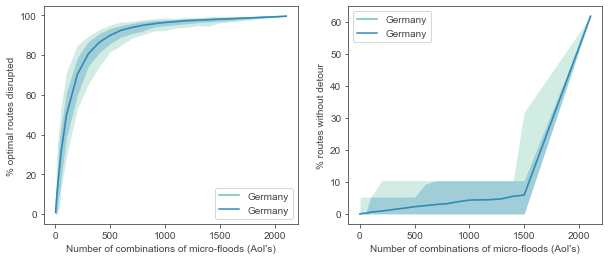

In [13]:
### Background layer: plot of Germany
from visualisations_new import aggregated_lineplot_new

#fig,axes = plt.subplots(1,3,figsize=(15,3))
fig,axes = plt.subplots(1,2,figsize=(10,4))

aggregated_lineplot_new(df_abs,['germany'],fill_between=('min','max'),save=False,fig=fig,ax=axes[0],clrs=[colors[7]])
aggregated_lineplot_new(df_abs,['germany'],fill_between=('q_05','q_95'),save=False,fig=fig,ax=axes[0],clrs=[colors[8]])

no_detour_aggregated_lineplot(no_dt_abs,['germany'],fill_between=('min','max'),save=False,fig=fig,ax=axes[1],clrs=[colors[7]])
no_detour_aggregated_lineplot(no_dt_abs,['germany'],fill_between=('q_05','q_95'),save=False,fig=fig,ax=axes[1],clrs=[colors[8]])

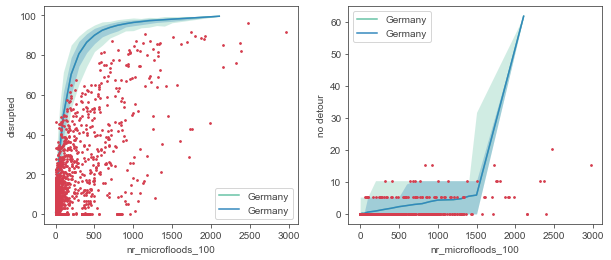

In [14]:
df.plot(x='nr_microfloods_100',y='disrupted',kind='scatter',color=colors[1],ax=axes[0],s=3,zorder=4)
df.plot(x='nr_microfloods_100',y='no detour',kind='scatter',color=colors[1],ax=axes[1],s=3,zorder=4)
fig

### Todo: filter out the AoIs abroad

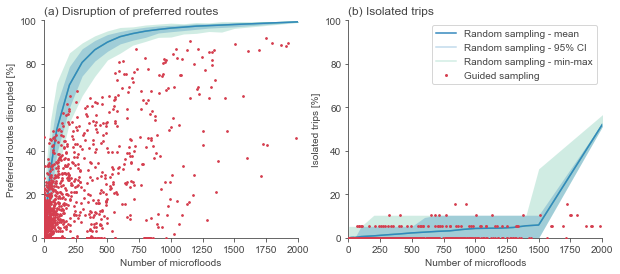

In [15]:
for ax in axes:
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    ax.set_xlabel(xlabel='Number of microfloods')
    ax.set_ylim(0,100)
    ax.set_xlim(0,2000)
    
# axes[2].tick_params(
#     axis='both',          # changes apply to the x-axis
#     which='both',      # both major and minor ticks are affected
#     bottom=False,      # ticks along the bottom edge are off
#     top=False,         # ticks along the top edge are off
#     left = False,
#     right = False,
#     labelbottom=False,
#     labelleft=False) # labels along the bottom edge are off
# axes[2].set_xlabel(None)

axes[0].set_ylabel('Preferred routes disrupted [%]')
axes[1].set_ylabel('Isolated trips [%]')    

axes[0].set_title('(a) Disruption of preferred routes',loc='left')
axes[1].set_title('(b) Isolated trips',loc='left')



# PREPARE LEGEND
handles0 = []
handles0.append(Line2D([0], [0], marker=None, color=colors[8], label='Random sampling - mean'))
handles0.append(Line2D([0], [0], marker=None, color=colors[8], alpha=0.3, label='Random sampling - 95% CI'))
handles0.append(Line2D([0], [0], marker=None, color=colors[7], alpha=0.3, label='Random sampling - min-max'))
handles0.append(Line2D([0], [0], marker='o', color='none', markerfacecolor=colors[1], label='Guided sampling', markeredgecolor='none',markersize=3))

axes[0].legend().remove()
axes[1].legend(handles=handles0,title=None,loc='upper right')

fig

In [16]:
dest_dir = Path('Germany-sampling')
name = 'compare_to_random'
#fig.savefig(dest_dir / (this_version + '_' + name + '.png'),dpi=300,bbox_inches='tight')
#fig.savefig(dest_dir / (this_version + '_' + name + '.pdf'),bbox_inches='tight')

In [17]:
axes[0].set_xlim(0,100)
axes[0].set_ylim(0,40)
fig
dest_dir = Path('Germany-sampling')
name = 'compare_to_random_detail'
fig.savefig(dest_dir / (this_version + '_' + name + '.png'),dpi=300,bbox_inches='tight')
fig.savefig(dest_dir / (this_version + '_' + name + '.pdf'),bbox_inches='tight')

### count # events above threshold

In [18]:
threshold = 80 #%
Type = 'disrupted'


def count_events_above_threshold(df,Type,threshold):
    """
    E.g. df = df, Type = 'disrupted', threshold = 80
    returns number events above that threshold
    
    """
    sel = df.loc[df[Type] >= threshold]
    return sel.shape[0]

sel = count_events_above_threshold(df,Type,threshold)

x_values = range(0,101)
freq_disrupted = [count_events_above_threshold(df,'disrupted',x) / 10_000 for x in x_values]

freq_nodetour = [count_events_above_threshold(df,'no detour',x) / 10_000 for x in x_values]


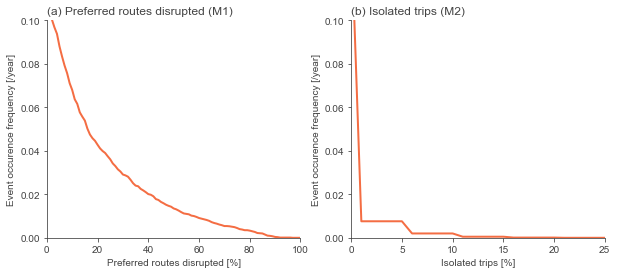

In [19]:
fig,axes = plt.subplots(1,2,figsize=(10,4))
ax = axes[0]
ax.plot(x_values,freq_disrupted,c=colors[2],lw=2)
ax.set_ylim(0,0.10)
ax.set_xlim(0,100)
ax.set_title('(a) Preferred routes disrupted (M1)',loc='left')
ax.set_xlabel('Preferred routes disrupted [%]')
ax.set_ylabel('Event occurence frequency [/year]')

ax = axes[1]

ax.plot(x_values,freq_nodetour,c=colors[2],lw=2)
ax.set_ylim(0,0.10)
ax.set_xlim(0,25)
ax.set_title('(b) Isolated trips (M2)',loc='left')
ax.set_xlabel('Isolated trips [%]')
ax.set_ylabel('Event occurence frequency [/year]')



for ax in axes:
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

In [20]:
dest_dir = Path('Germany-sampling')
name = 'frequency'
#fig.savefig(dest_dir / (this_version + '_' + name + '.png'),dpi=300,bbox_inches='tight')
#fig.savefig(dest_dir / (this_version + '_' + name + '.pdf'),bbox_inches='tight')

In [21]:
count_events_above_threshold(df,'disrupted',50)

135

### Values for in the paper

In [64]:
print(freq_disrupted[50],freq_disrupted[80])
print(freq_nodetour[5],freq_nodetour[10])

0.0135 0.0033
0.0076 0.002


In [65]:
#return period
print(1/freq_disrupted[50],1/freq_disrupted[80])
print(1/freq_nodetour[5],1/freq_nodetour[10])

74.07407407407408 303.03030303030306
131.57894736842104 500.0


### Select some extreme values

In [73]:
Sort_disr = df.sort_values(by='disrupted',ascending=False)
Sort_disr.iloc[0:10]

,year,disrupted,avg extra time,no detour,nr_basinfloods_100,nr_basinfloods_50,nr_microfloods_100,nr_microfloods_50
614,614.0,89.189189,1.792982,10.384068,67,91,1508,2008
983,983.0,88.620199,1.772606,5.263158,82,95,1870,2500
2128,2128.0,88.051209,2.080915,5.263158,94,101,1910,2054
3130,3130.0,87.055477,0.888253,5.263158,54,87,1037,1986
3479,3479.0,86.913229,0.741631,5.263158,53,83,724,1553
116,116.0,85.348506,0.853887,0.000000,61,75,1299,1521
2646,2646.0,84.495021,0.869508,0.000000,52,74,1013,1674
838,838.0,83.214794,1.326599,5.263158,75,79,1247,1319
2188,2188.0,82.645804,0.956050,5.263158,56,77,797,1248
815,815.0,81.650071,1.713878,5.263158,35,54,963,1245


In [74]:
topyears_disr = list(Sort_disr[0:3].index)
topyears_disr

[614, 983, 2128]

### Look into some extreme events for relatively low aois

In [30]:
threshold = (20,8)
x_values = list(range(0,21))
y_values = [(8/20)*x for x in x_values]

df2['threshold'] = df2['AoI combinations'].apply(lambda x: ((8/20)*x))
df2['above'] = df2['disrupted'] >= df2['threshold']

<AxesSubplot:xlabel='AoI combinations', ylabel='disrupted'>

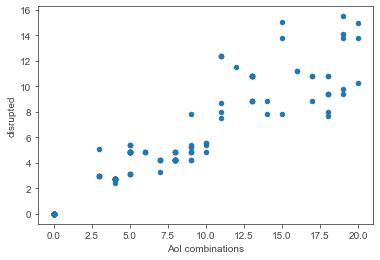

In [33]:
df_above = df2.loc[df2['above']]
df_above.plot(x='AoI combinations',y='disrupted',kind='scatter')

In [43]:
AoI_in_df_above = []
for value in df_above['AoI removed']:
    AoI_in_df_above.extend(value)

In [ ]:
from collections import Counter
c = Counter(AoI_in_df_above)
c.most_common()

### Compare statistics of both distributions

In [85]:
gs = groups.size()
gs.iloc[0:50]

nr_microfloods_100
0     99
1      1
2      1
4      5
5      6
6     20
7      3
8      5
9      4
10     3
11     6
12     4
13     3
14     2
15     1
16     3
17     4
18     1
19     1
21     3
22     3
24     2
25     1
26     1
28     1
29     1
30     4
31     2
32     1
33     3
34     1
35     1
36     1
37     3
38     4
39     1
40     3
41     3
44     3
45     2
46     1
47     1
48     1
49     5
50     5
51     3
52     2
53     1
54     1
55     1
dtype: int64

In [93]:
x = groups['disrupted'].describe()
x.head(n=8)

,count,mean,std,min,25%,50%,75%,max
nr_microfloods_100,,,,,,,,
0,99.0,4.324899,5.558841,0.000000,0.000000,2.987198,6.401138,27.453770
1,1.0,1.422475,NaN,1.422475,1.422475,1.422475,1.422475,1.422475
2,1.0,0.284495,NaN,0.284495,0.284495,0.284495,0.284495,0.284495
4,5.0,4.523471,5.986576,0.000000,0.000000,2.987198,5.120910,14.509246
5,6.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,20.0,2.389758,3.601449,0.000000,0.000000,0.000000,4.836415,11.095306
7,3.0,5.547653,9.608817,0.000000,0.000000,0.000000,8.321479,16.642959
8,5.0,1.166430,1.861215,0.000000,0.000000,0.000000,1.564723,4.267425


In [117]:
y = df_ref.loc[df_ref['country']=='Germany']
y = y.groupby('AoI combinations').median()
y.head()

,disrupted,avg extra time,no detour,AoI relative combinations
AoI combinations,,,,
1,0.000000,0.000000,0.0,0.047483
2,0.000000,0.000000,0.0,0.094967
3,1.280228,0.000613,0.0,0.142450
4,1.991465,0.000988,0.0,0.189934
5,2.560455,0.001433,0.0,0.237417


In [128]:
#interpolate all median values for all whole integers 0tm100

values = list(range(0,101))
col = 'disrupted'
y['AoI combinations'] = y.index
arr = y[['AoI combinations',col]].to_numpy()
arr = np.insert(arr,obj=0,values=np.array([0,0]),axis=0) #add 0,0 point
assert sorted(arr[:,0] == arr[:,0]) #check if list is sorted (needed for interpolation function)
interpolated = np.interp(x=values,xp=arr[:,0],fp=arr[:,1])
interpolated

array([ 0.        ,  0.        ,  0.        ,  1.2802276 ,  1.99146515,
        2.56045519,  3.84068279,  4.40967283,  4.33854908,  6.11664296,
        7.25462304,  7.85206259,  8.44950213,  9.04694168,  9.64438122,
       10.24182077, 10.83926031, 11.43669986, 12.0341394 , 12.63157895,
       13.22901849, 13.80512091, 14.38122333, 14.95732575, 15.53342816,
       16.10953058, 16.685633  , 17.26173542, 17.83783784, 18.41394026,
       18.99004267, 19.58036984, 20.17069701, 20.76102418, 21.35135135,
       21.94167852, 22.53200569, 23.12233286, 23.71266003, 24.3029872 ,
       24.89331437, 25.52631579, 26.15931721, 26.79231864, 27.42532006,
       28.05832148, 28.6913229 , 29.32432433, 29.95732575, 30.59032717,
       31.22332859, 31.60312945, 31.9829303 , 32.36273116, 32.74253201,
       33.12233286, 33.50213372, 33.88193457, 34.26173542, 34.64153628,
       35.02133713, 35.40113798, 35.78093884, 36.16073969, 36.54054054,
       36.9203414 , 37.30014225, 37.6799431 , 38.05974396, 38.43

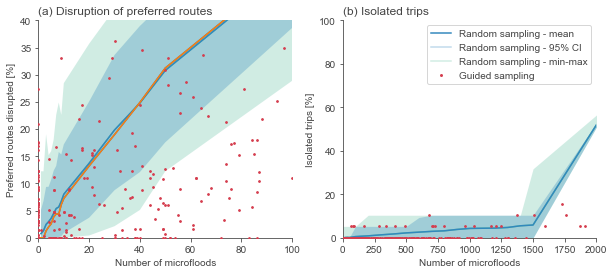

In [127]:
fig
axes[0].plot(values,interpolated)
fig

In [138]:
dfs = df.loc[df['nr_microfloods_100'] <= 100]
dfs['random_median'] = dfs['nr_microfloods_100'].apply(lambda x: interpolated[x])
dfs

,year,disrupted,avg extra time,no detour,nr_basinfloods_100,nr_basinfloods_50,nr_microfloods_100,nr_microfloods_50,random_median
4,4.0,0.000000,0.000000,0.0,0,1,0,4,0.000000
12,12.0,8.819346,0.025458,0.0,1,3,0,18,0.000000
18,18.0,0.284495,0.000120,0.0,1,8,2,450,0.000000
20,20.0,5.120910,0.002973,0.0,0,10,0,220,0.000000
28,28.0,0.000000,0.000000,0.0,3,4,39,51,24.302987
...,...,...,...,...,...,...,...,...,...
3471,3471.0,3.129445,0.002886,0.0,0,2,0,18,0.000000
3490,3490.0,0.000000,0.000000,0.0,0,2,0,372,0.000000
3493,3493.0,11.806543,0.013225,0.0,5,8,45,434,28.058321
3510,3510.0,21.337127,0.135843,0.0,4,14,74,357,40.338549


In [140]:
dfs_above = dfs.loc[dfs['disrupted'] > dfs['random_median']]
dfs_above

,year,disrupted,avg extra time,no detour,nr_basinfloods_100,nr_basinfloods_50,nr_microfloods_100,nr_microfloods_50,random_median
12,12.0,8.819346,0.025458,0.0,1,3,0,18,0.000000
18,18.0,0.284495,0.000120,0.0,1,8,2,450,0.000000
20,20.0,5.120910,0.002973,0.0,0,10,0,220,0.000000
60,60.0,5.120910,0.002973,0.0,0,1,0,4,0.000000
94,94.0,24.466572,0.041017,0.0,1,12,17,296,11.436700
...,...,...,...,...,...,...,...,...,...
3277,3277.0,5.974395,0.044948,0.0,0,8,0,83,0.000000
3329,3329.0,46.088193,0.112505,0.0,4,36,74,485,40.338549
3395,3395.0,8.819346,0.025458,0.0,1,4,12,42,8.449502
3428,3428.0,16.927454,0.041948,0.0,0,5,0,60,0.000000


In [142]:
dfs_below = dfs.loc[dfs['disrupted'] <= dfs['random_median']] 
dfs_below

,year,disrupted,avg extra time,no detour,nr_basinfloods_100,nr_basinfloods_50,nr_microfloods_100,nr_microfloods_50,random_median
4,4.0,0.000000,0.000000,0.0,0,1,0,4,0.000000
28,28.0,0.000000,0.000000,0.0,3,4,39,51,24.302987
30,30.0,25.889047,0.061379,0.0,5,13,61,265,35.401138
35,35.0,34.850640,0.082849,0.0,10,20,97,196,49.073969
36,36.0,0.000000,0.000000,0.0,0,1,0,6,0.000000
...,...,...,...,...,...,...,...,...,...
3464,3464.0,12.944523,0.022142,0.0,3,6,22,75,14.381223
3490,3490.0,0.000000,0.000000,0.0,0,2,0,372,0.000000
3493,3493.0,11.806543,0.013225,0.0,5,8,45,434,28.058321
3510,3510.0,21.337127,0.135843,0.0,4,14,74,357,40.338549


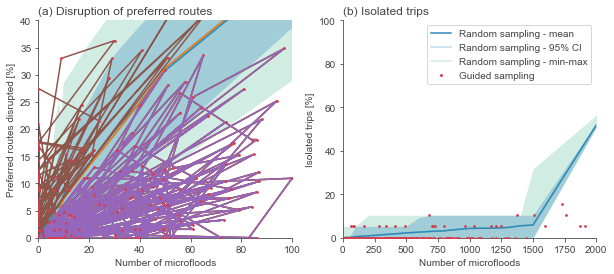

In [145]:
axes[0].plot(dfs_below['nr_microfloods_100'],dfs_below['disrupted'])
axes[0].plot(dfs_above['nr_microfloods_100'],dfs_above['disrupted'])
fig

In [146]:
91/281

0.3238434163701068

In [147]:
190/281

0.6761565836298933

# same thing for isolated trips

In [149]:
values = list(range(0,1501))
col = 'no detour'
y['AoI combinations'] = y.index
arr = y[['AoI combinations',col]].to_numpy()
arr = np.insert(arr,obj=0,values=np.array([0,0]),axis=0) #add 0,0 point
assert sorted(arr[:,0] == arr[:,0]) #check if list is sorted (needed for interpolation function)
interpolated = np.interp(x=values,xp=arr[:,0],fp=arr[:,1])
interpolated

array([0.        , 0.        , 0.        , ..., 5.26315789, 5.26315789,
       5.26315789])